In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import network_utils as nuts
import physically_informed_loss_functions as pilf

In [2]:
dev_train_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_device.xlsx')
train_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_train.xlsx')
test_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_test.xlsx')

dev_only_x = dev_train_df[['Time (min)', 'Temp (C)']]
dev_only_y = dev_train_df[['PCE', 'VocL', 'Jsc', 'FF']]
x_train = train_df[['Anneal_time', 'Anneal_temp',
                   'p1_fraction', 'p2_fraction', 'p3_fraction',
                   'p1_area_avg', 'p1_area_stdev', 'p1_filled_area_avg',
                   'p1_filled_area_stdev', 'p1_extent_avg', 'p1_extent_stdev',
                   'p1_MajorAL_avg', 'p1_MajorAL_stdev', 'p1_MinorAL_avg',
                   'p1_MinorAL_stdev', 'p1_Ecc_avg', 'p1_Ecc_stdev','p1_Orient_avg',
                   'p1_Orient_stdev', 'p1_Perim_avg', 'p1_Perim_stdev',

                   'p2_area_avg', 'p2_area_stdev', 'p2_filled_area_avg',
                   'p2_filled_area_stdev', 'p2_extent_avg', 'p2_extent_stdev',
                   'p2_MajorAL_avg', 'p2_MajorAL_stdev', 'p2_MinorAL_avg',
                   'p2_MinorAL_stdev', 'p2_Ecc_avg', 'p2_Ecc_stdev','p2_Orient_avg',
                   'p2_Orient_stdev', 'p2_Perim_avg', 'p2_Perim_stdev',

                   'p3_area_avg', 'p3_area_stdev', 'p3_filled_area_avg',
                   'p3_filled_area_stdev', 'p3_extent_avg', 'p3_extent_stdev',
                   'p3_MajorAL_avg', 'p3_MajorAL_stdev', 'p3_MinorAL_avg',
                   'p3_MinorAL_stdev', 'p3_Ecc_avg', 'p3_Ecc_stdev','p3_Orient_avg',
                   'p3_Orient_stdev', 'p3_Perim_avg', 'p3_Perim_stdev']]
y_train = train_df[['PCE', 'VocL', 'Jsc', 'FF']]

x_test = test_df[['Anneal_time', 'Anneal_temp',
                   'p1_fraction', 'p2_fraction', 'p3_fraction',
                   'p1_area_avg', 'p1_area_stdev', 'p1_filled_area_avg',
                   'p1_filled_area_stdev', 'p1_extent_avg', 'p1_extent_stdev',
                   'p1_MajorAL_avg', 'p1_MajorAL_stdev', 'p1_MinorAL_avg',
                   'p1_MinorAL_stdev', 'p1_Ecc_avg', 'p1_Ecc_stdev','p1_Orient_avg',
                   'p1_Orient_stdev', 'p1_Perim_avg', 'p1_Perim_stdev',

                   'p2_area_avg', 'p2_area_stdev', 'p2_filled_area_avg',
                   'p2_filled_area_stdev', 'p2_extent_avg', 'p2_extent_stdev',
                   'p2_MajorAL_avg', 'p2_MajorAL_stdev', 'p2_MinorAL_avg',
                   'p2_MinorAL_stdev', 'p2_Ecc_avg', 'p2_Ecc_stdev','p2_Orient_avg',
                   'p2_Orient_stdev', 'p2_Perim_avg', 'p2_Perim_stdev',

                   'p3_area_avg', 'p3_area_stdev', 'p3_filled_area_avg',
                   'p3_filled_area_stdev', 'p3_extent_avg', 'p3_extent_stdev',
                   'p3_MajorAL_avg', 'p3_MajorAL_stdev', 'p3_MinorAL_avg',
                   'p3_MinorAL_stdev', 'p3_Ecc_avg', 'p3_Ecc_stdev','p3_Orient_avg',
                   'p3_Orient_stdev', 'p3_Perim_avg', 'p3_Perim_stdev']]
y_test = test_df[['PCE', 'VocL', 'Jsc', 'FF']]

After loading in the data and splitting it into our training and testing datasets, it's time for some curve fitting and hyper-parameter optimization. This notebook optimizes the Random Forest fitting on the above datasets

First, we need to define some functions to train, optimize, and compare the Random Forest regression results for predicting the 4 different OPV device parameters, PCE, V$_{OC}$, J$_{SC}$, and FF.

In [3]:
def mean_absolute_accuracy(labels, predictions):
    """
    This is a function to calculate the % accuracy of a batch of labels and 
    predictions made by a model.
    """
    
    accuracies = []
    labels = labels.to_numpy()
    for x, y in zip(predictions, labels):
        accuracy = np.abs(((y - x) / y)) * 100
        accuracies.append(accuracy)
        
    mean_accuracy = sum(accuracies)/len(accuracies)
        
    return mean_accuracy


def RF(x_fit, y_fit, x_test, y_test, depth):
    """
    This function fits sklearn's random forest regressor to data and returns train and test MSE,
    the final predicted labels, and the losses and coefficients of fit.
    """
    
    tree = DecisionTreeRegressor(max_depth = depth)
    tree.fit(x_train, y_train)

    y_train_pred = tree.predict(x_train)
    y_test_pred = tree.predict(x_test)


    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    test_accuracy = mean_absolute_accuracy(y_test, y_test_pred)
    
    return y_test_pred, train_mse, test_mse, test_accuracy

def RF_depth_opt(x_fit, y_fit, x_test, y_test, lower, upper):
    """
    This function calls RF across a range of tree depths and returns the best performing
    depth, its index, and all the losses, and accuracies for each depth.
    """
    
    depths = np.arange(lower, upper, step = 1)

    train_errors = []
    test_errors = []

    best_depths = []
    best_errors = []
    accuracies = []

    for i, d in enumerate(depths):
        y_test_pred, train_mse, test_mse, test_accuracy = RF(x_fit, y_fit, x_test, y_test, d)
        
        train_errors.append(train_mse)
        test_errors.append(test_mse)
        accuracies.append(test_accuracy)
        
        if i > 1:
            if test_errors[-1] <= test_errors[-2]:
                best_depths.append(d)
                best_errors.append(test_mse)
                
            else:
                pass
        else:
            best_depths.append(d)
            best_errors.append(test_mse)

    best_acc = min(accuracies)
    depth_idx = accuracies.index(best_acc)
    best_alpha = depths[alpha_idx]
    

    return train_errors, test_errors, best_depth, depth_idx, accuracies

def OPV_RF(x_train, y_train, x_test, y_test):
    """
    This function fits and optimizes 4 different sklearn Decision Tree instances to predict 4
    different OPV device performances, given the input information about the devices.
    """
    
    pce_train = y_train['PCE']
    pce_test = y_test['PCE']
    voc_train = y_train['VocL']
    voc_test = y_test['VocL']
    jsc_train = y_train['Jsc']
    jsc_test = y_test['Jsc']
    ff_train = y_train['FF']
    ff_test = y_test['FF']
    
    #Fit LASSO with a range of alphas for performance metric
    lower = 1
    upper = 30
    
    depths = np.arange(lower, upper, step = 1)
    
    pce_trn_err, pce_tst_err, pce_d, pce_idx, pce_accs  = RF_depth_opt(x_train, pce_train,
                                                                     x_test, pce_test,
                                                                     lower = lower,
                                                                     upper = upper)
    voc_trn_err, voc_tst_err, voc_d, voc_idx, voc_accs = RF_depth_opt(x_train, voc_train,
                                                                    x_test, voc_test,
                                                                    lower = lower,
                                                                    upper = upper)
    jsc_trn_err, jsc_tst_err, jsc_d, jsc_idx, jsc_accs = RF_depth_opt(x_train, jsc_train,
                                                                    x_test, jsc_test,
                                                                    lower = lower,
                                                                    upper = upper)
    ff_trn_err, ff_tst_err, ff_d, ff_idx, ff_accs = RF_depth_opt(x_train, ff_train,
                                                                x_test, ff_test,
                                                                lower = lower,
                                                                upper = upper)
    total_trn_err = []
    total_tst_err = []
    for pce1, pce2, voc1, voc2, jsc1, jsc2, ff1, ff2 in zip(pce_trn_err, pce_tst_err,
                                                            voc_trn_err, voc_tst_err,
                                                            jsc_trn_err, jsc_tst_err,
                                                            ff_trn_err, ff_tst_err):
        
        total_trn_err.append((pce1 + voc1 + jsc1 + ff1))
        total_tst_err.append((pce2 + voc2 + jsc2 + ff2))
    
    
    fig, ax = plt.subplots(figsize = (12, 8))
    plt.plot(depths, total_trn_err, c = 'k', marker = '|', label = 'total train')
    plt.plot(depths, total_tst_err, c = 'k', marker = '>', label = 'total test')
    ax.set_ylabel('MSE')
    ax.set_xlabel('alpha')
    plt.legend(loc = 'best')
    ax.set_xscale('log')
    plt.show()
    
    fig, ax = plt.subplots(figsize = (12, 8))
    plt.plot(depths, pce_trn_err, c = 'k', marker = '|', label = 'pce train')
    plt.plot(depths, pce_tst_err, c = 'k', marker = '>', label = 'pce test')
    plt.plot(depths, voc_trn_err, c = 'r', marker = '|', label = 'voc train')
    plt.plot(depths, voc_tst_err, c = 'r', marker = '>', label = 'voc test')
    plt.plot(depths, jsc_trn_err, c = 'b', marker = '|', label = 'jsc train')
    plt.plot(depths, jsc_tst_err, c = 'b', marker = '>', label = 'jsc test')
    plt.plot(depths, ff_trn_err, c = 'g', marker = '|', label = 'ff train')
    plt.plot(depths, ff_tst_err, c = 'g', marker = '>', label = 'ff test')
    ax.set_ylabel('MSE')
    ax.set_xlabel('depths')
    plt.legend(loc = 'best')
#     ax.set_xscale('log')
    plt.show()
    
    avg_acc = []
    for pce, voc, jsc, ff in zip(pce_accs, voc_accs, jsc_accs, ff_accs):
        
        avg_acc.append(((pce + voc + jsc + ff)/4))
    
    fig, ax = plt.subplots(figsize = (12,8))
    plt.plot(depths, avg_acc, c = 'k', marker = '>', label = 'mean acc')
    plt.scatter(depths[avg_acc.index(min(avg_acc))], min(avg_acc))
    plt.plot(depths, pce_accs, c = 'r', marker = '|', label = 'pce acc')
    plt.plot(depths, voc_accs, c = 'g', marker = '|', label = 'voc acc')
    plt.plot(depths, jsc_accs, c = 'b', marker = '|', label = 'jsc acc')
    plt.plot(depths, ff_accs, c = 'cyan', marker = '|', label = 'ff acc')
    ax.set_ylabel('Average Absolute Percent Error (%)')
    ax.set_xlabel('depths')
    plt.legend(loc = 'best')
#     ax.set_xscale('log')
    plt.show()
    
    #For the best alpha for each LASSO, final fit and predict test labels
    pce_pred, pce_train_mse, pce_test_mse, pce_acc, pce_coeffs = RF(x_train, pce_train, x_test,
                                                              pce_test, pce_d)
    voc_pred, voc_train_mse, voc_test_mse, voc_acc, voc_coeffs = RF(x_train, voc_train, x_test,
                                                              voc_test, voc_d)
    jsc_pred, jsc_train_mse, jsc_test_mse, jsc_acc, jsc_coeffs = RF(x_train, jsc_train, x_test,
                                                              jsc_test, jsc_d)
    ff_pred, ff_train_mse, ff_test_mse, ff_acc, ff_coeffs = RF(x_train,ff_train, x_test,
                                                          ff_test, ff_d)
    
    
    nuts.plot_OPV_parity(pce_test, pce_pred, voc_test, voc_pred, jsc_test, jsc_pred, ff_test, ff_pred)
    
    
    OPV_LASSO_dict = {
        'pce' : [pce_pred, pce_train_mse, pce_test_mse, pce_coeffs, pce_accs],
        'voc' : [voc_pred, voc_train_mse, voc_test_mse, voc_coeffs, voc_accs],
        'jsc' : [jsc_pred, jsc_train_mse, jsc_test_mse, jsc_coeffs, jsc_accs],
        'ff' : [jsc_pred, jsc_train_mse, jsc_test_mse, jsc_coeffs, ff_accs]
    }
    
    return OPV_LASSO_dict

In [4]:
params = {
    'criterion' : ['mse', 'mae'],
    'max_depth' : np.arange(1, 31, step = 1),
    'min_samples_split' : [2, 3, 4],
    'max_leaf_nodes': np.arange(2, 31, step = 1)
}

rf_pce = GridSearchCV(DecisionTreeRegressor(),
                 param_grid = params)
rf_voc = GridSearchCV(DecisionTreeRegressor(),
                 param_grid = params)
rf_jsc = GridSearchCV(DecisionTreeRegressor(),
                 param_grid = params)
rf_ff = GridSearchCV(DecisionTreeRegressor(),
                 param_grid = params)

In [5]:
rf_pce.fit(x_train, y_train['PCE'])
rf_voc.fit(x_train, y_train['VocL'])
rf_jsc.fit(x_train, y_train['Jsc'])
rf_ff.fit(x_train, y_train['FF'])


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=...
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,

In [7]:
pce_params = rf_pce.best_params_
voc_params = rf_voc.best_params_
jsc_params = rf_jsc.best_params_
ff_params = rf_ff.best_params_

print(pce_params)
print(voc_params)
print(jsc_params)
print(ff_params)

{'criterion': 'mae', 'max_depth': 29, 'max_leaf_nodes': 10, 'min_samples_split': 2}
{'criterion': 'mse', 'max_depth': 3, 'max_leaf_nodes': 17, 'min_samples_split': 3}
{'criterion': 'mae', 'max_depth': 30, 'max_leaf_nodes': 5, 'min_samples_split': 3}
{'criterion': 'mse', 'max_depth': 28, 'max_leaf_nodes': 30, 'min_samples_split': 3}


In [8]:
pce_preds = rf_pce.predict(x_test)
voc_preds = rf_voc.predict(x_test)
jsc_preds = rf_jsc.predict(x_test)
ff_preds = rf_ff.predict(x_test)

%autoreload

mape = pilf.reg_MAPE()

pce_mse = mean_squared_error(pce_preds, y_test['PCE'])
pce_r2 = r2_score(pce_preds, y_test['PCE'])
pce_mape = mape.forward(pce_preds, y_test['PCE'])

print(f'mse = {pce_mse}, mape = {pce_mape}, r2 = {pce_r2}')

voc_mse = mean_squared_error(voc_preds, y_test['VocL'])
voc_r2 = r2_score(voc_preds, y_test['VocL'])
voc_mape = mape.forward(voc_preds, y_test['VocL'])

print(f'mse = {voc_mse}, mape = {voc_mape}, r2 = {voc_r2}')

jsc_mse = mean_squared_error(jsc_preds, y_test['Jsc'])
jsc_r2 = r2_score(jsc_preds, y_test['Jsc'])
jsc_mape = mape.forward(jsc_preds, y_test['Jsc'])

print(f'mse = {jsc_mse}, mape = {jsc_mape}, r2 = {jsc_r2}')

ff_mse = mean_squared_error(ff_preds, y_test['FF'])
ff_r2 = r2_score(ff_preds, y_test['FF'])
ff_mape = mape.forward(ff_preds, y_test['FF'])

print(f'mse = {ff_mse}, mape = {ff_mape}, r2 = {ff_r2}')

mse = 0.1804094671958981, mape = 36.196491521437416, r2 = -0.2132037280427692
mse = 0.19967560416009028, mape = 32.423474065628284, r2 = -0.4488011870337394
mse = 0.1546175437512999, mape = 23.659380111126378, r2 = -0.170413788631254
mse = 0.10786407593415141, mape = 18.18543508553516, r2 = -0.3430343869818777


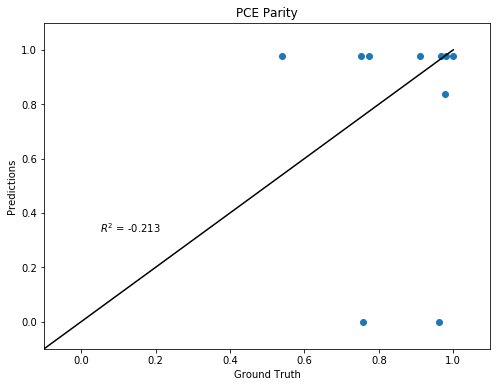

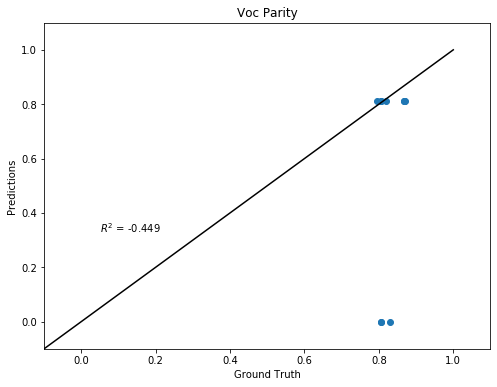

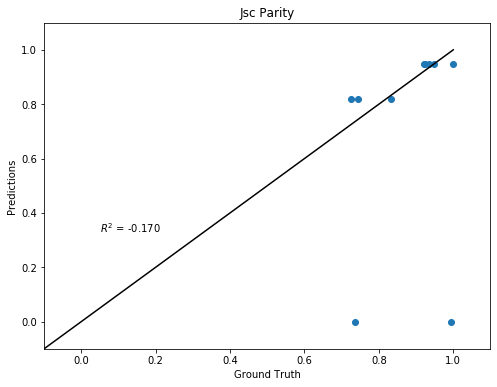

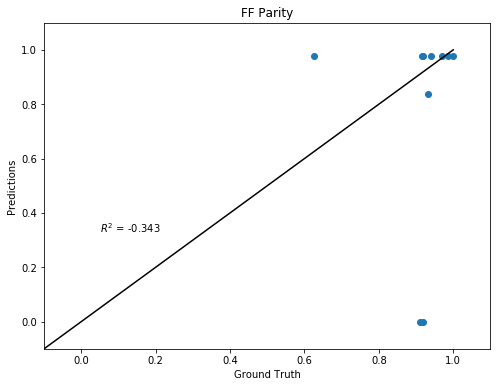

In [9]:
xlin = ylin = np.arange(-2, 2, 1)

r2 = r2_score(pce_preds, y_test['PCE'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['PCE'], pce_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('PCE Parity')
plt.show()

r2 = r2_score(voc_preds, y_test['VocL'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['VocL'], voc_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Voc Parity')
plt.show()

r2 = r2_score(jsc_preds, y_test['Jsc'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['Jsc'], jsc_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Jsc Parity')
plt.show()

r2 = r2_score(ff_preds, y_test['FF'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['FF'], pce_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('FF Parity')
plt.show()

# Device data only regression

In [10]:
params = {
    'criterion' : ['mse', 'mae'],
    'max_depth' : np.arange(1, 31, step = 1),
    'min_samples_split' : [2, 3, 4],
    'max_leaf_nodes': np.arange(2, 31, step = 1)
}

rf_pce = GridSearchCV(DecisionTreeRegressor(),
                 param_grid = params)
rf_voc = GridSearchCV(DecisionTreeRegressor(),
                 param_grid = params)
rf_jsc = GridSearchCV(DecisionTreeRegressor(),
                 param_grid = params)
rf_ff = GridSearchCV(DecisionTreeRegressor(),
                 param_grid = params)

rf_pce.fit(dev_only_x, dev_only_y['PCE'])
rf_voc.fit(dev_only_x, dev_only_y['VocL'])
rf_jsc.fit(dev_only_x, dev_only_y['Jsc'])
rf_ff.fit(dev_only_x, dev_only_y['FF'])

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=...
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,

In [11]:
pce_params = rf_pce.best_params_
voc_params = rf_voc.best_params_
jsc_params = rf_jsc.best_params_
ff_params = rf_ff.best_params_

print(pce_params)
print(voc_params)
print(jsc_params)
print(ff_params)

{'criterion': 'mse', 'max_depth': 27, 'max_leaf_nodes': 10, 'min_samples_split': 3}
{'criterion': 'mae', 'max_depth': 1, 'max_leaf_nodes': 2, 'min_samples_split': 2}
{'criterion': 'mae', 'max_depth': 2, 'max_leaf_nodes': 4, 'min_samples_split': 2}
{'criterion': 'mae', 'max_depth': 5, 'max_leaf_nodes': 6, 'min_samples_split': 2}


In [14]:
pce_preds = rf_pce.predict(x_test[['Anneal_time', 'Anneal_temp']])
voc_preds = rf_voc.predict(x_test[['Anneal_time', 'Anneal_temp']])
jsc_preds = rf_jsc.predict(x_test[['Anneal_time', 'Anneal_temp']])
ff_preds = rf_ff.predict(x_test[['Anneal_time', 'Anneal_temp']])

%autoreload

mape = pilf.reg_MAPE()

pce_mse = mean_squared_error(pce_preds, y_test['PCE'])
pce_r2 = r2_score(pce_preds, y_test['PCE'])
pce_mape = mape.forward(pce_preds, y_test['PCE'])

print(f'mse = {pce_mse}, mape = {pce_mape}, r2 = {pce_r2}')

voc_mse = mean_squared_error(voc_preds, y_test['VocL'])
voc_r2 = r2_score(voc_preds, y_test['VocL'])
voc_mape = mape.forward(voc_preds, y_test['VocL'])

print(f'mse = {voc_mse}, mape = {voc_mape}, r2 = {voc_r2}')

jsc_mse = mean_squared_error(jsc_preds, y_test['Jsc'])
jsc_r2 = r2_score(jsc_preds, y_test['Jsc'])
jsc_mape = mape.forward(jsc_preds, y_test['Jsc'])

print(f'mse = {jsc_mse}, mape = {jsc_mape}, r2 = {jsc_r2}')

ff_mse = mean_squared_error(ff_preds, y_test['FF'])
ff_r2 = r2_score(ff_preds, y_test['FF'])
ff_mape = mape.forward(ff_preds, y_test['FF'])

print(f'mse = {ff_mse}, mape = {ff_mape}, r2 = {ff_r2}')

mse = 0.02884170934624989, mape = 18.12546381014554, r2 = -0.5271757632675973
mse = 0.0024910787236442486, mape = 4.849979251023122, r2 = 0.0
mse = 0.006628590098636866, mape = 7.423015730260501, r2 = -0.3050117304471496
mse = 0.04301263387497894, mape = 16.319404058917097, r2 = -0.36842063467773656


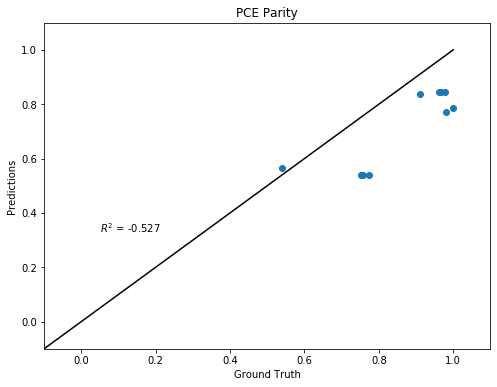

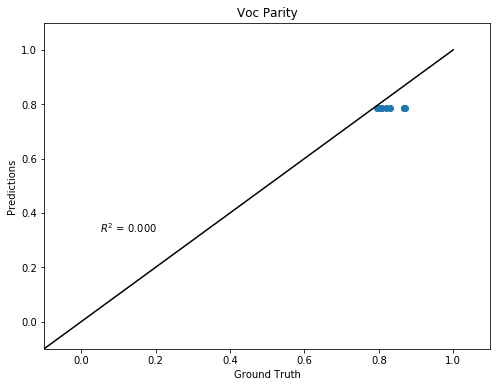

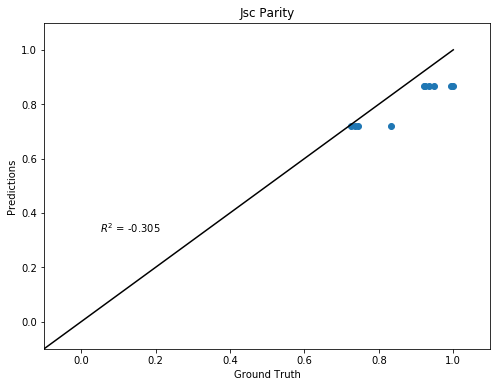

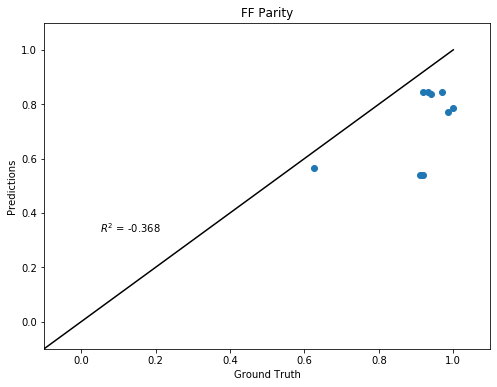

In [15]:
xlin = ylin = np.arange(-2, 2, 1)

r2 = r2_score(pce_preds, y_test['PCE'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['PCE'], pce_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('PCE Parity')
plt.show()

r2 = r2_score(voc_preds, y_test['VocL'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['VocL'], voc_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Voc Parity')
plt.show()

r2 = r2_score(jsc_preds, y_test['Jsc'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['Jsc'], jsc_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('Jsc Parity')
plt.show()

r2 = r2_score(ff_preds, y_test['FF'])
fig, ax = plt.subplots(figsize = (8,6))
plt.scatter(y_test['FF'], pce_preds)
plt.plot(xlin, ylin, c = 'k')
ax.annotate(f"$R^{2}$ = {r2:.3f}", xy = (0.2, 0.4), xycoords = 'figure fraction')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("Predictions")
ax.set_xlabel("Ground Truth")
plt.title('FF Parity')
plt.show()